In [ ]:
import torch, evaluate, numpy as np, wandb, multiprocessing, random, time
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torchvision.transforms import (
    Compose,
    
    GaussianBlur,
    ColorJitter,
    RandomAffine,
    RandomVerticalFlip,
    RandomRotation,
    RandomHorizontalFlip,
    RandomResizedCrop,

    CenterCrop,
    Resize,
    Normalize,
    ToTensor,
)
duration = 60 * 60


# seed = torch.random.initial_seed()
# torch.manual_seed(seed)

#Parameters
testset_size = 0.3
epoch = 1
batch_size = 8
lr = 5e-5
ds = load_dataset("imagefolder", data_dir="/home/dxd_jy/joel/Capstone/For_Training/Training_Dataset")

labels1 = ds["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels1):
    label2id[label] = i
    id2label[i] = label

name = f"{len(id2label)}L_{epoch}E_{batch_size}B_{lr}_{testset_size}"

# To try:
# ResNeXt, DenseNet

# nvidia/mit-b5 
# microsoft/resnet-152
# google/efficientnet-b5 (0.8737)
# google/mobilenet_v2_1.0_224 (0.7355)
# microsoft/swinv2-base-patch4-window8-256 (0.8987)
# facebook/deit-base-patch16-224 (0.8969)
# microsoft/beit-base-patch16-224 (0.9194)

# google/vit-base-patch16-224
# google/vit-base-patch16-384
# google/vit-base-patch32-384
model_checkpoint = "microsoft/beit-base-patch16-384"
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

# def random_kernel_size():
#     return random.randint(1,3) * 2 + 1

train_transforms = Compose(
        [
            #GaussianBlur(kernel_size=random_kernel_size(), sigma=(0.01, 1)),
            #ColorJitter(brightness=(0.5,2), contrast=(0.5,3), saturation=(0.1,3), hue=(-0.5,0.5)),
            # RandomAffine(degrees=90),
            #RandomVerticalFlip(),
            #RandomRotation(degrees=90),
            RandomHorizontalFlip(),
            RandomResizedCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""

    labels = eval_pred.label_ids
    predictions = np.argmax(eval_pred.predictions, axis=1)

    accuracy_results    = accuracy.compute(predictions=predictions, references=labels)
    f1_results          = f1.compute(predictions=predictions, references=labels, average="weighted")
    precision_results   = precision.compute(predictions=predictions, references=labels, average="weighted")
    recall_results      = recall.compute(predictions=predictions, references=labels, average="weighted")
    combined_results    = {**accuracy_results, **f1_results, **precision_results, **recall_results}
 
    wandb.log({"Train_f1": f1_results["f1"], "Train_prec": precision_results["precision"], "Train_recall": recall_results["recall"]})
    return combined_results

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

model_name = model_checkpoint.split("/")[-1]
run_name = f"{model_name}-{name}"

args = TrainingArguments(
    run_name,
    remove_unused_columns=          False,
    evaluation_strategy=            "epoch",
    save_strategy=                  "epoch",
    learning_rate=                  lr,
    per_device_train_batch_size=    batch_size,
    gradient_accumulation_steps=    4,
    per_device_eval_batch_size=     batch_size,
    num_train_epochs=               epoch,
    warmup_ratio=                   0.1,
    log_level=                      "info",
    logging_steps=                  1,
    logging_strategy=               "epoch",
    load_best_model_at_end=         True,
    save_total_limit=               1, 
    metric_for_best_model=          "accuracy",
    report_to=                      "wandb"
)

seed = 1026847926404610400
#seed = random.randint(1, 2**63 - 1)

# split up training into training + validation and evaluation
splits = ds["train"].train_test_split(test_size=testset_size, stratify_by_column="label", seed=seed)
train_ds = splits['train']
val_ds = splits['test']

splits2 = val_ds.train_test_split(test_size=0.5, stratify_by_column="label", seed=seed)
val_ds = splits2['train']
eval_ds = splits2['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val) 
eval_ds.set_transform(preprocess_val) 

In [ ]:
eval_ds[0]['image']

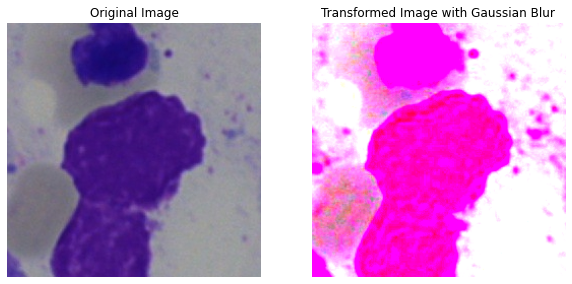

In [319]:
from PIL import Image
import matplotlib.pyplot as plt, random
from torchvision.transforms import (
    Compose,
    
    GaussianBlur,
    ColorJitter,
    RandomAffine,
    RandomVerticalFlip,
    RandomRotation,
    RandomHorizontalFlip,
    RandomResizedCrop,

    CenterCrop,
    Resize,
    Normalize,
    ToTensor,
)

# Load your sample image
image_path = "/home/dxd_jy/joel/Capstone/Training_Testing/Test/Test_Images/Images/ART_19630.jpg"
image = Image.open(image_path)

# def random_kernel_size():
#     return random.randint(1,5) * 2 + 1

# def random_gaussian_blur(test):
#     if test < 0.5:
#         return GaussianBlur(kernel_size=random_kernel_size(), sigma=(0.5, 3))
#     else:
#         return lambda x: x

# # Apply random Gaussian blur
# transformed_image = random_gaussian_blur()(image)

def random_jitter(test):
    if test < 0.5:
        return ColorJitter(brightness=(0.5,2), contrast=(0.5,3), saturation=(0.1,3), hue=(-0.5,0.5))
    else:
        return lambda x: x

transformed_image = random_jitter(0)(image)

# Plot original and transformed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(transformed_image)
axes[1].set_title('Transformed Image with Gaussian Blur')
axes[1].axis('off')
plt.show()
